In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.gridspec as gridspec
import torch.optim as optim
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.nn.functional as F
import math 
from pennylane import qml
from PIL import Image
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

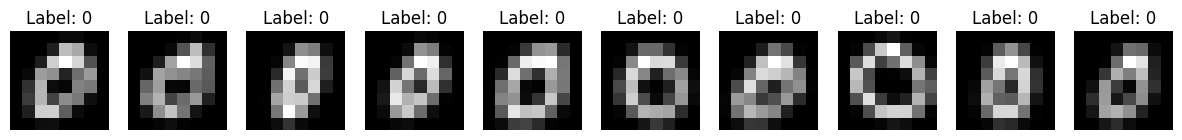

In [2]:
IMG_SIZE = 8  # Dimensione delle immagini (8x8)
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Ridimensiona le immagini a 8x8
    transforms.ToTensor()  # Converte le immagini in tensori
])

# Scarica il dataset MNIST con la trasformazione applicata
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Crea sottoinsiemi per le cifre 0 e 1
indices_zero = [i for i, (_, label) in enumerate(trainset) if label == 0]
indices_one = [i for i, (_, label) in enumerate(trainset) if label == 1]

zero_subset = Subset(trainset, indices_zero)
one_subset = Subset(trainset, indices_one)

# Combina i due sottoinsiemi
combined_subset = ConcatDataset([zero_subset, one_subset])

trainloader = DataLoader(combined_subset, batch_size=BATCH_SIZE, shuffle=True)

# Funzione per visualizzare le immagini
def show_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

# Visualizza alcune immagini del dataset combinato
show_images(combined_subset, num_images=10)

In [3]:
def count_batches(dataloader):
    num_batches = 0
    for _ in dataloader:
        num_batches += 1
    return num_batches

# Conta e stampa il numero di batch nel dataloader
num_batches = count_batches(trainloader)
print(f"Number of batches: {num_batches}")

Number of batches: 396


In [4]:


def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Ridimensiona a 4x4
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Scala i dati in [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scala tra [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.MNIST(root=".", download=True, 
                                       transform=data_transform, train=True)

    test = torchvision.datasets.MNIST(root=".", download=True, 
                                      transform=data_transform, train=False)
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))
    plt.axis('off')  # Rimuove i ticks degli assi
    plt.show()

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [5]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(IMG_SIZE  * IMG_SIZE , 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [6]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

In [7]:
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
class PatchQuantumGenerator(nn.Module):
    def __init__(self, q_depth=6, n_qubits=5, n_generators=4,device='default.qubit.torch', q_delta=1):
        super(PatchQuantumGenerator, self).__init__()
        self.q_depth = q_depth
        self.n_qubits = n_qubits
        self.n_generators = n_generators
        self.dev = qml.device(device, wires=self.n_qubits, torch_device='cuda')
        self.weight_shapes = {"weights": qml.StronglyEntanglingLayers.shape(n_layers=q_depth, n_wires=self.n_qubits)}
        self.qnode = qml.QNode(self.circuit, self.dev, interface='torch')
        self.q_params = nn.ParameterList([
            nn.Parameter(q_delta * torch.rand(q_depth, n_qubits), requires_grad=True)
            for _ in range(n_generators)
        ])
        self.qlayers = nn.ModuleList([
            qml.qnn.TorchLayer(self.qnode, self.weight_shapes) for _ in range(n_generators)
        ])
    
    def circuit(self, inputs, weights):
        qml.AngleEmbedding(features=inputs, wires=range(self.n_qubits), rotation="Y")
        qml.StronglyEntanglingLayers(weights=weights, wires=range(self.n_qubits))
        return qml.probs(wires=list(range(self.n_qubits)))

    def forward(self, x):
        patches = []
        for i in range(self.n_generators):
            probs = self.qlayers[i](x)
            probsgiven0 = probs[:, : (2 ** (self.n_qubits - n_a_qubits))]
            probsgiven0 /= torch.sum(probs, dim=1, keepdim=True)
            probsgiven = probsgiven0 / torch.max(probsgiven0, dim=1, keepdim=True)[0]
            patches.append(probsgiven)
        images = torch.cat(patches, dim=1)
        return images

In [9]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 1000  # Number of training iterations
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator().to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((BATCH_SIZE,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((BATCH_SIZE,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

In [10]:
import matplotlib.pyplot as plt

def plot_losses(generator_losses, discriminator_losses):
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(generator_losses, label="G")
    plt.plot(discriminator_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [11]:
generator_losses = []
discriminator_losses = []
num_epochs = 3
counter = 0

# Collect images for plotting later
results = []

with tqdm(total=num_epochs * len(trainloader), desc="Training Progress") as pbar:
    for epoch in range(num_epochs):
        for i, (data, _) in enumerate(tqdm(trainloader, desc=f"Batch Progress (Epoch {epoch+1})", leave=False)):
            if data.size(0) != BATCH_SIZE:
                continue
            data = data.reshape(-1, IMG_SIZE * IMG_SIZE)
            real_data = data.to(device)

            # Noise following a uniform distribution in range [0, pi/2)
            noise = torch.rand(BATCH_SIZE, n_qubits, device=device) * math.pi / 2
            fake_data = generator(noise)

            # Training the discriminator
            discriminator.zero_grad()
            outD_real = discriminator(real_data).view(-1)
            outD_fake = discriminator(fake_data.detach()).view(-1)

            errD_real = criterion(outD_real, real_labels)
            errD_fake = criterion(outD_fake, fake_labels)
            # Propagate gradients
            errD_real.backward()
            errD_fake.backward()

            errD = errD_real + errD_fake
            optD.step()

            # Training the generator
            generator.zero_grad()
            outD_fake = discriminator(fake_data).view(-1)
            errG = criterion(outD_fake, real_labels)
            errG.backward()
            optG.step()

            generator_losses.append(errG.item())
            discriminator_losses.append(errD.item())
            
            counter += 1
            pbar.update(1)  # Aggiorna la barra di progresso

            # Show loss values
            if counter % 10 == 0:
                pbar.set_postfix({'D Loss': f'{errD:.3f}', 'G Loss': f'{errG:.3f}'})
                test_images = generator(fixed_noise).view(8, 1, IMG_SIZE, IMG_SIZE).cpu().detach()

                # Save images every 50 iterations
                if counter % 50 == 0:
                    results.append(test_images)

Training Progress: 100%|█████████▉| 1185/1188 [14:44<00:02,  1.34it/s, D Loss=1.243, G Loss=0.873]


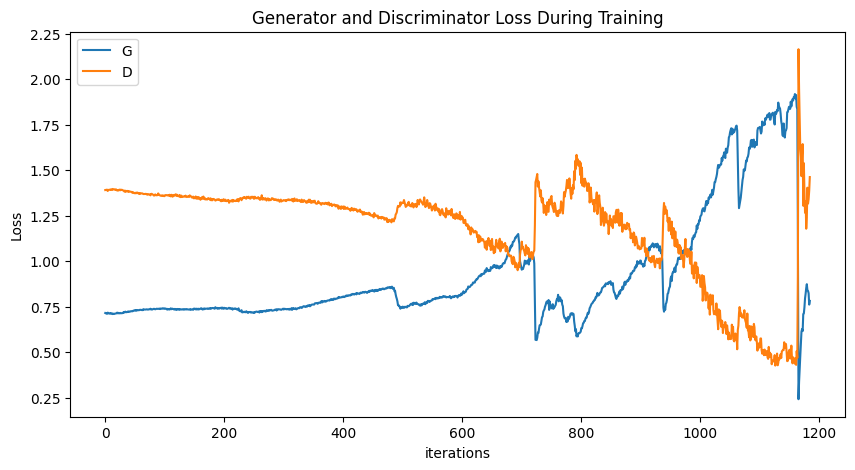

In [12]:
plot_losses(generator_losses, discriminator_losses)

In [13]:
output_dir = 'generated_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Funzione per salvare un'immagine
def save_image(img, path):
    img = (img * 255).astype(np.uint8)  # Converti in formato 0-255
    Image.fromarray(img).save(path)

# Itera attraverso tutte le immagini in results e salvale
for i, images in enumerate(results):
    images = torch.squeeze(images, dim=1)  # Rimuovi la dimensione del canale se presente
    for j, im in enumerate(images):
        img_path = os.path.join(output_dir, f'iteration_{50+i*50}_image_{j}.png')
        save_image(im.numpy(), img_path)

print(f"Tutte le immagini generate sono state salvate in: {os.path.abspath(output_dir)}")

Tutte le immagini generate sono state salvate in: c:\Users\pevel\OneDrive\Documenti\Python Scripts\Tesi\Quantum_gan\generated_images


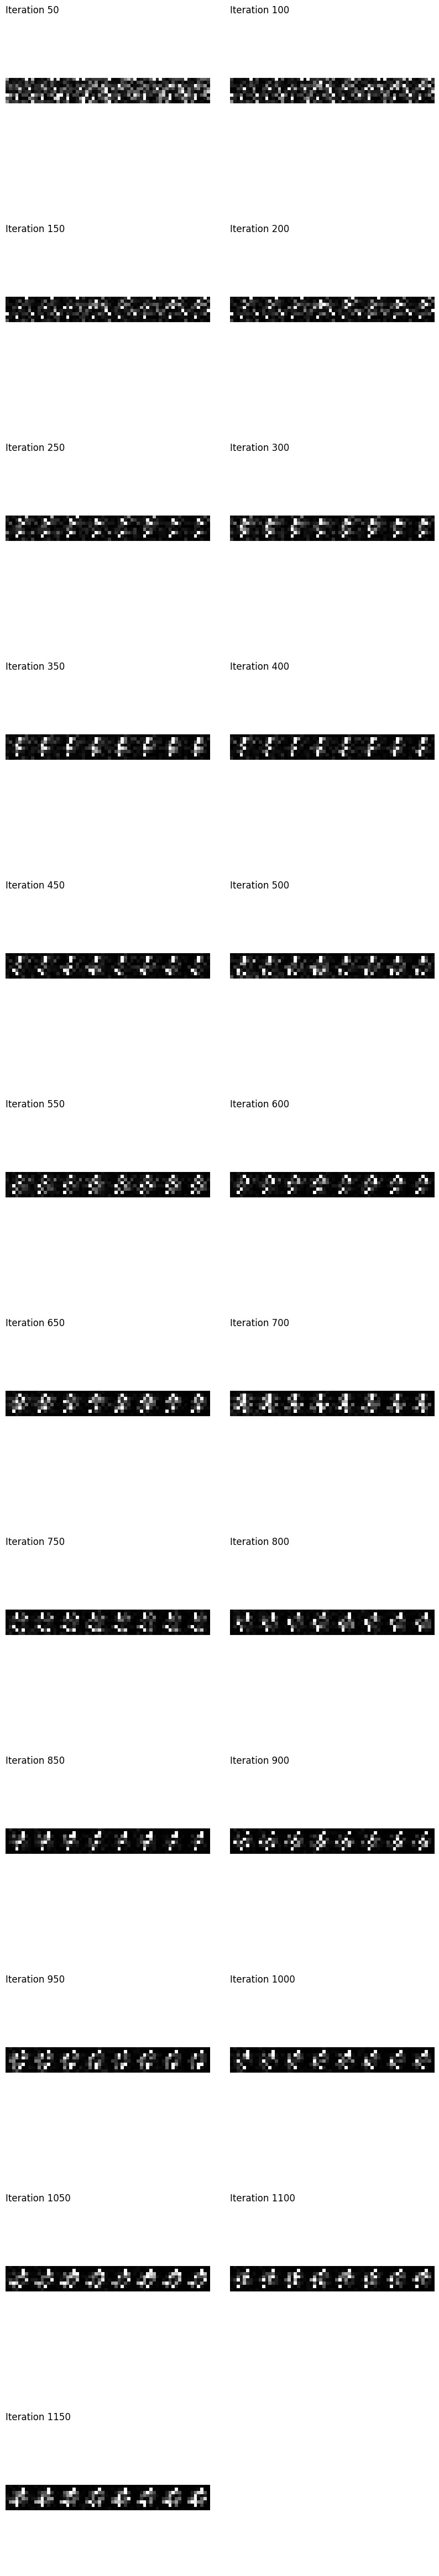

In [14]:

# Calcola il numero di righe necessarie
n_rows = (len(results) + 1) // 2

# Crea la figura e i subplot
fig, axs = plt.subplots(n_rows, 2, figsize=(10, 5 * n_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

# Appiattisci l'array di axes se necessario
if n_rows > 1:
    axs = axs.flatten()
else:
    axs = [axs]

for i, images in enumerate(results):
    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):
        if j == 0:
            axs[i].set_title(f'Iteration {50+i*50}', loc='left')
        
        # Calcola la posizione per ogni immagine all'interno del subplot
        pos = axs[i].get_position()
        fig.add_axes([pos.x0 + j * pos.width / len(images), 
                      pos.y0, 
                      pos.width / len(images), 
                      pos.height])
        plt.imshow(im.numpy(), cmap="gray")
        plt.axis('off')
    
    # Rimuovi l'asse originale del subplot
    axs[i].axis('off')

# Rimuovi eventuali subplot vuoti
for i in range(len(results), len(axs)):
    fig.delaxes(axs[i])

plt.show()

In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_mse(real_images, generated_images):
    # Assicuriamoci che le dimensioni corrispondano
    min_samples = min(real_images.shape[0], generated_images.shape[0])
    real_images = real_images[:min_samples]
    generated_images = generated_images[:min_samples]
    
    mse = mean_squared_error(real_images.flatten(), generated_images.flatten())
    return mse

# Assumendo che real_batch sia un batch di immagini reali e generated_images siano le immagini generate
real_batch = next(iter(trainloader))[0].numpy()
generated_images = generator(fixed_noise).detach().cpu().numpy()

# Stampiamo le forme per debug
print("Shape of real_batch:", real_batch.shape)
print("Shape of generated_images:", generated_images.shape)

mse = calculate_mse(real_batch, generated_images)
print(f"Mean Squared Error: {mse}")

Shape of real_batch: (32, 1, 8, 8)
Shape of generated_images: (8, 64)
Mean Squared Error: 0.07430291175842285


In [16]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(real_images, generated_images):
    # Assicuriamoci che le dimensioni corrispondano
    min_samples = min(real_images.shape[0], generated_images.shape[0])
    real_images = real_images[:min_samples]
    generated_images = generated_images[:min_samples]
    
    ssim_scores = []
    for real, gen in zip(real_images, generated_images):
        # Assicuriamoci che le immagini abbiano la stessa forma
        real = real.squeeze()
        gen = gen.squeeze()
        
        # Ridimensioniamo se necessario
        if real.shape != gen.shape:
            gen = np.resize(gen, real.shape)
        
        score = ssim(real, gen, data_range=gen.max() - gen.min())
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Assumendo che real_batch sia un batch di immagini reali e generated_images siano le immagini generate
real_batch = next(iter(trainloader))[0].numpy()
generated_images = generator(fixed_noise).detach().cpu().numpy()

# Stampiamo le forme per debug
print("Shape of real_batch:", real_batch.shape)
print("Shape of generated_images:", generated_images.shape)

ssim_score = calculate_ssim(real_batch, generated_images)
print(f"Average SSIM Score: {ssim_score}")

Shape of real_batch: (32, 1, 8, 8)
Shape of generated_images: (8, 64)
Average SSIM Score: 0.3780134990811348


In [15]:

NUM_IMAGES = 100 

def save_images(images, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i, image in enumerate(images):
        img = transforms.ToPILImage()(image.squeeze())
        img.save(os.path.join(directory, f'image_{i:04d}.png'))

# Directory per salvare le immagini
real_dir = 'real_images'
fake_dir = 'fake_images'

# Salva le immagini reali
print("Salvando le immagini reali...")
for i, (images, _) in enumerate(trainloader):
    save_images(images, real_dir)
    if (i+1) * BATCH_SIZE >= NUM_IMAGES:
        break

# Genera e salva le immagini fake (rumore casuale)
print("Generando e salvando le immagini fake...")
fake_images = torch.rand(NUM_IMAGES, 1, IMG_SIZE, IMG_SIZE)
save_images(fake_images, fake_dir)

print(f"Immagini reali salvate in: {os.path.abspath(real_dir)}")
print(f"Immagini fake salvate in: {os.path.abspath(fake_dir)}")
print("\nOra puoi calcolare il FID usando il seguente comando:")
print(f"python -m pytorch_fid {os.path.abspath(real_dir)} {os.path.abspath(fake_dir)}")

Salvando le immagini reali...
Generando e salvando le immagini fake...
Immagini reali salvate in: c:\Users\pevel\OneDrive\Desktop\Tesi\Tesi\Quantum_gan\real_images
Immagini fake salvate in: c:\Users\pevel\OneDrive\Desktop\Tesi\Tesi\Quantum_gan\fake_images

Ora puoi calcolare il FID usando il seguente comando:
python -m pytorch_fid c:\Users\pevel\OneDrive\Desktop\Tesi\Tesi\Quantum_gan\real_images c:\Users\pevel\OneDrive\Desktop\Tesi\Tesi\Quantum_gan\fake_images


In [12]:
current_dir = os.getcwd()

# Vai alla directory superiore
parent_dir = os.path.dirname(current_dir)

# Crea il percorso completo per la cartella "weights"
weights_dir = os.path.join(parent_dir, 'weights')

# Crea la cartella "weights" se non esiste
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

In [13]:
generator_path = os.path.join(weights_dir, f'quantum_generator.pth')
discriminator_path = os.path.join(weights_dir, f'discriminator.pth')
    
generator.load_state_dict(torch.load(generator_path))
discriminator.load_state_dict(torch.load(discriminator_path))
print(f"Modelli caricati")

Modelli caricati


In [21]:
generator_path = os.path.join(weights_dir, f'quantum_generator_epoch_{epoch}.pth')
discriminator_path = os.path.join(weights_dir, f'discriminator_epoch_{epoch}.pth')
    
torch.save(generator.state_dict(), generator_path)
torch.save(discriminator.state_dict(), discriminator_path)
print(f"Modelli salvati per l'epoca {epoch} in {weights_dir}")

Modelli salvati per l'epoca 2 in c:\Users\pevel\OneDrive\Documenti\Python Scripts\Tesi\weights


In [18]:
import torch
import math
from tqdm import tqdm
import os
from torchvision.utils import save_image

# Assuming these are defined elsewhere in your code
# generator, n_qubits, IMG_SIZE, device

# Create the directory if it doesn't exist
os.makedirs("generated_images", exist_ok=True)

# Set the generator to evaluation mode
generator.eval()

# Number of images to generate
num_images = 100

with torch.no_grad():  # Disable gradient computation
    for i in tqdm(range(num_images), desc="Generating images"):
        # Generate noise
        noise = torch.rand(1, n_qubits, device=device) * math.pi / 2
        
        # Generate an image
        fake_image = generator(noise)
        
        # Reshape and scale the image
        fake_image = fake_image.view(1, IMG_SIZE, IMG_SIZE)
        fake_image = (fake_image + 1) / 2.0  # Scale from [-1, 1] to [0, 1]
        
        # Save the image
        save_image(fake_image, f"generated_images/generated_image_{i+1}.png")

print(f"Generated {num_images} images in the 'generated_images' folder.")

Generating images: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]

Generated 100 images in the 'generated_images' folder.


In [20]:
import os
import torch
from torchvision import transforms
from tqdm import tqdm

NUM_IMAGES = 100

def save_images(images, directory, start_index):
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i, image in enumerate(images):
        img = transforms.ToPILImage()(image.squeeze())
        img.save(os.path.join(directory, f'image_{start_index + i:04d}.png'))

# Directory to save the images
real_dir = 'real_images'

# Save the real images
print("Saving real images...")
saved_count = 0
with tqdm(total=NUM_IMAGES) as pbar:
    while saved_count < NUM_IMAGES:
        for images, _ in trainloader:
            batch_size = images.size(0)
            remaining = NUM_IMAGES - saved_count
            if batch_size > remaining:
                images = images[:remaining]
            
            save_images(images, real_dir, saved_count)
            
            saved_count += len(images)
            pbar.update(len(images))
            
            if saved_count >= NUM_IMAGES:
                break
        
        if saved_count < NUM_IMAGES:
            print(f"Reached end of dataset. Looping back to the beginning. Current count: {saved_count}")

print(f"Real images saved in: {os.path.abspath(real_dir)}")
print(f"Total images saved: {saved_count}")

Saving real images...


100%|██████████| 100/100 [00:00<00:00, 1337.79it/s]

Real images saved in: c:\Users\pevel\OneDrive\Desktop\Tesi\Tesi\Quantum_gan\real_images
Total images saved: 100
